In [1]:
import torch
import math
import matplotlib.pyplot as plt
import numpy as np

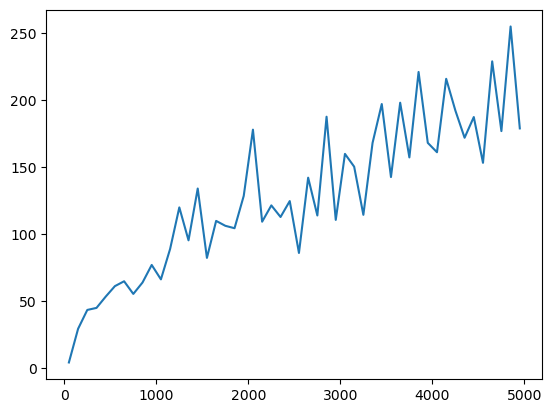

In [21]:
ratio = []
for d in range(50, 50000, 1000):
    g = torch.rand(d) + 10
    sketch = (torch.randn(20, d)) / math.sqrt(20)
    sketched_g = sketch.T @ sketch @ g
    ratio.append(torch.max(torch.abs(sketched_g)) / torch.max(torch.abs(g)))
plt.plot(torch.arange(50, 5000, 100), ratio)

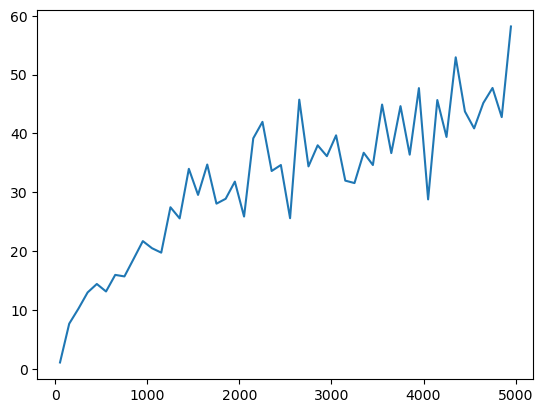

In [3]:
ratio = []
sum = []
for d in range(50, 50000, 1000):
    g = torch.rand(d) + 10
    sketch = (torch.randn(20, d)) / math.sqrt(20)
    sketched_g = sketch.T @ sketch @ g
    ratio.append(torch.norm(sketched_g) / torch.norm(g))
    sum.append(torch.sum(sketched_g) - torch.sum(g))
plt.plot(torch.arange(50, 5000, 100), ratio)
#plt.plot(torch.arange(50, 5000, 100), sum)

In [12]:
d = 50
sum = 0
samples = 20000
for _ in range(samples):
    g = torch.rand(d) + 10
    sketch = (torch.randn(20, d)) / math.sqrt(20)
    sketched_g = sketch.T @ sketch @ g
    sum += sketched_g - g
print(sum/samples)

tensor([ 0.1556, -0.0664,  0.1326,  0.2049, -0.0802, -0.1620,  0.1730,  0.0430,
         0.1208,  0.0406,  0.0669,  0.1050,  0.1285,  0.0177, -0.0810,  0.0154,
        -0.0317,  0.0023,  0.0381,  0.1175, -0.0495, -0.0517, -0.1061,  0.1957,
        -0.0249,  0.1164, -0.2098, -0.0136,  0.2116,  0.0487,  0.0602,  0.0118,
         0.0521,  0.0753,  0.0272, -0.0638,  0.1099, -0.0338, -0.2249, -0.0518,
        -0.0365, -0.0930,  0.0864,  0.0727,  0.0788,  0.2028,  0.1665,  0.1906,
        -0.1883, -0.0476])


In [4]:
sum

[tensor(-254.6975),
 tensor(1854.7422),
 tensor(-714.9844),
 tensor(2201.9453),
 tensor(1097.8125),
 tensor(-16091.4258),
 tensor(-11115.7461),
 tensor(-21076.2031),
 tensor(-11293.2812),
 tensor(4355.4922),
 tensor(-19190.5859),
 tensor(-33789.1094),
 tensor(32728.3906),
 tensor(904.5156),
 tensor(93406.6562),
 tensor(26338.9844),
 tensor(88693.9062),
 tensor(-11045.4375),
 tensor(-12145.2812),
 tensor(8899.6406),
 tensor(-70787.1875),
 tensor(95713.9688),
 tensor(139683.2500),
 tensor(-6942.7500),
 tensor(-156.4531),
 tensor(-125468.5156),
 tensor(170942.8438),
 tensor(-34606.4375),
 tensor(4853.3750),
 tensor(-32233.3750),
 tensor(15814.2188),
 tensor(-111367.0312),
 tensor(-127073.3594),
 tensor(-62338.5312),
 tensor(-104159.9219),
 tensor(59962.8125),
 tensor(-90805.9062),
 tensor(33215.2500),
 tensor(-119049.6875),
 tensor(72747.7500),
 tensor(-242890.3125),
 tensor(5697.5000),
 tensor(-116520.2812),
 tensor(135593.1562),
 tensor(-65729.2500),
 tensor(-118922.2188),
 tensor(-5797

In [22]:
torch.mean(torch.diag(sketch.T @ sketch))

tensor(1.0004)

256 tensor(0.0747)
512 tensor(0.0760)
1024 tensor(0.0775)
2048 tensor(0.0788)
4096 tensor(0.0794)


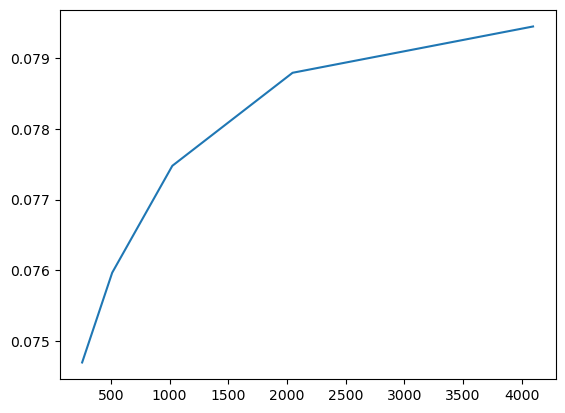

In [37]:
basis_std = math.sqrt(0.02)
init_wn_norm = []
for prev_width in [256, 512, 1024, 2048, 4096]:
    weight = torch.zeros(prev_width, prev_width)
    torch.nn.init.uniform_(weight, a=-basis_std/np.sqrt(prev_width), b=basis_std/np.sqrt(prev_width))
    #torch.nn.init.normal_(weight, 0, basis_std/np.sqrt(prev_width))
    print(prev_width, torch.min(torch.norm(weight, dim=1)))
    init_wn_norm.append(torch.min(torch.norm(weight, dim=1)))
plt.plot([256, 512, 1024, 2048, 4096], init_wn_norm)

In [3]:
"""
Comparison of manual BatchNorm2d layer implementation in Python and
nn.BatchNorm2d

@author: ptrblck
"""

import torch
import torch.nn as nn


def compare_bn(bn1, bn2):
    err = False
    if not torch.allclose(bn1.running_mean, bn2.running_mean):
        print('Diff in running_mean: {} vs {}'.format(
            bn1.running_mean, bn2.running_mean))
        err = True

    if not torch.allclose(bn1.running_var, bn2.running_var):
        print('Diff in running_var: {} vs {}'.format(
            bn1.running_var, bn2.running_var))
        err = True

    if bn1.affine and bn2.affine:
        if not torch.allclose(bn1.weight, bn2.weight):
            print('Diff in weight: {} vs {}'.format(
                bn1.weight, bn2.weight))
            err = True

        if not torch.allclose(bn1.bias, bn2.bias):
            print('Diff in bias: {} vs {}'.format(
                bn1.bias, bn2.bias))
            err = True

    if not err:
        print('All parameters are equal!')


class MyBatchNorm2d(nn.BatchNorm2d):
    def __init__(self, num_features, eps=1e-5, momentum=0.1,
                 affine=True, track_running_stats=True):
        print("in init")
        print(self.running_mean)
        super(MyBatchNorm2d, self).__init__(
            num_features, eps, momentum, affine, track_running_stats)
        print("in init")
        print(self.running_mean)

    def forward(self, input):
        print(self.running_mean)
        self._check_input_dim(input)

        exponential_average_factor = 0.0

        if self.training and self.track_running_stats:
            if self.num_batches_tracked is not None:
                self.num_batches_tracked += 1
                if self.momentum is None:  # use cumulative moving average
                    exponential_average_factor = 1.0 / float(self.num_batches_tracked)
                else:  # use exponential moving average
                    exponential_average_factor = self.momentum

        # calculate running estimates
        if self.training:
            mean = input.mean([0, 2, 3])
            # use biased var in train
            var = input.var([0, 2, 3], unbiased=False)
            n = input.numel() / input.size(1)
            #with torch.no_grad():
            self.running_mean = exponential_average_factor * mean\
                + (1 - exponential_average_factor) * self.running_mean
            # update running_var with unbiased var
            self.running_var = exponential_average_factor * var * n / (n - 1)\
                + (1 - exponential_average_factor) * self.running_var
            self.running_mean.retain_grad()
            #print(self.running_mean)
        else:
            mean = self.running_mean
            var = self.running_var

        input = (input - mean[None, :, None, None]) / (torch.sqrt(var[None, :, None, None] + self.eps))
        if self.affine:
            input = input * self.weight[None, :, None, None] + self.bias[None, :, None, None]

        return input


# Init BatchNorm layers
my_bn = MyBatchNorm2d(3, affine=True)
bn = nn.BatchNorm2d(3, affine=True)

#my_bn.running_mean.retain_grad()

compare_bn(my_bn, bn)  # weight and bias should be different
# Load weight and bias
my_bn.load_state_dict(bn.state_dict())
compare_bn(my_bn, bn)

# Run train
for run in range(10):
    print(run)
    scale = torch.randint(1, 10, (1,)).float()
    bias = torch.randint(-10, 10, (1,)).float()
    x = torch.randn(10, 3, 100, 100) * scale + bias
    out1 = my_bn(x)
    out2 = bn(x)
    
    torch.mean(out1).backward()
    print(my_bn.running_mean.grad)

    compare_bn(my_bn, bn)

    torch.allclose(out1, out2)
    print('Max diff: ', (out1 - out2).abs().max())

# Run eval
my_bn.eval()
bn.eval()
for _ in range(10):
    scale = torch.randint(1, 10, (1,)).float()
    bias = torch.randint(-10, 10, (1,)).float()
    x = torch.randn(10, 3, 100, 100) * scale + bias
    out1 = my_bn(x)
    out2 = bn(x)
    compare_bn(my_bn, bn)

    torch.allclose(out1, out2)
    print('Max diff: ', (out1 - out2).abs().max())

in init


AttributeError: 'MyBatchNorm2d' object has no attribute 'running_mean'

In [2]:
out2.shape

torch.Size([10, 3, 100, 100])

In [30]:
eta = 0.1
x = torch.nn.parameter.Parameter(torch.tensor(1.0))
y = torch.nn.parameter.Parameter(torch.tensor(2.0))
z = x * y
m = 2 * z
z.retain_grad()
(m + x**2).backward()

#x = x - eta * x.grad
#y = y - eta * y.grad
#x.grad, y.grad = None, None


In [31]:
x.grad

tensor(6.)

In [32]:
z.grad

tensor(2.)